# Creating the Historical Visualization

In [5]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

In [42]:
df = pd.read_pickle("data/historical_outbreaks.pkl")

print(type(df))

<class 'pandas.core.frame.DataFrame'>


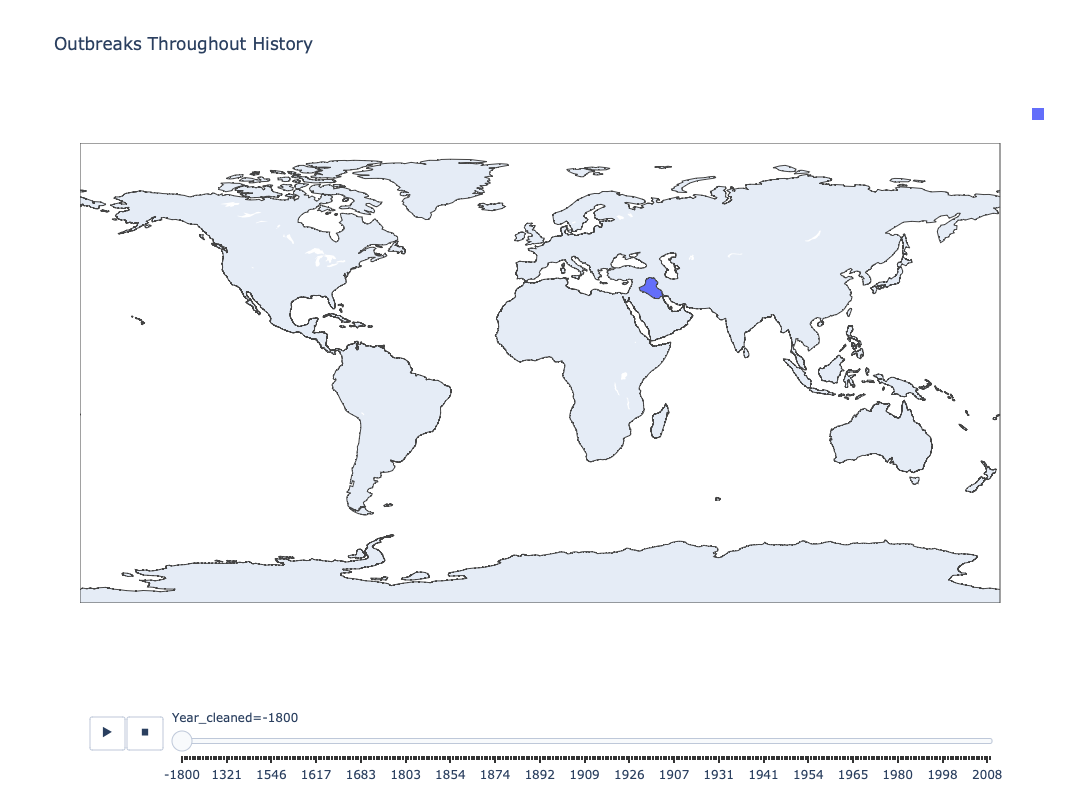

In [43]:
fig = px.choropleth(
    df,
    locations="Country",
    locationmode='ISO-3',
    animation_frame='Year_cleaned',
    animation_group='Epidemic',
    title="Outbreaks Throughout History",
    hover_data=['Country', 'Description'],
    height=800,
    width=800,
)
fig.show()

In [37]:
# Function to update the map for a selected year
def plot_for_year(year, df=pd.DataFrame()):
    # Filter the DataFrame for the selected year
    #print(df)
    filtered_df = df.loc[df['Year_cleaned'] == year]
    
    # Create the choropleth map
    fig = px.choropleth(filtered_df,
                        locations="Country",
                        locationmode='ISO-3',
                        title=f"Outbreaks in the Year {year}",
                        hover_data=['Country', 'Description'],
                        height=800,
                        width=800,
                       )
                        
    fig.show()
    

# Create a slider widget with the unique years
year_slider = widgets.SelectionSlider(
    options=df.Year_cleaned.unique(),
    description='Year',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

# Display the slider and bind the update function

widgets.interactive(plot_for_year, year=year_slider, df=widgets.fixed(df))

interactive(children=(SelectionSlider(continuous_update=False, description='Year', options=(-1800, -400, -1320…